In [1]:
from sqlite3 import SQLITE_CREATE_VIEW
import anndata
import scanpy as sc
import os
#from bbknn import bbknn
import matplotlib.pyplot as plt
import omicverse as ov
#import scib
from scvi.model.utils import mde
#from scib_metrics.benchmark import Benchmarker
import scvi
#import scanorama
import numpy as np
#import pyliger
#from harmony import harmonize
from rich import print
import seaborn as sns
#import bbknn
#import doubletdetection
%matplotlib inline
import pandas as pd

plt.rcParams.update({'font.size': 12})
plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are saved as text, not outlines
# Change the font to 'DejaVu Sans' or another available font
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.3, Tutorials: https://omicverse.readthedocs.io/


[rank: 0] Global seed set to 0


In [2]:
#####Change path and Load data
os.chdir("/storage/liuxiaodongLab/fanxueying/mayanalysis/2024Aug")
adata = anndata.read_h5ad("human_monkey_reanno.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 175274 × 84580
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'leiden_res0_8', 'leiden_res1_0', 'leiden_res1_2', 'reanno2', 'leiden_res1_0_sub', 'reanno_3'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'hvg', 'leiden', 'leiden_res0_8_colors', 'leiden_res1_0_colors', 'leiden_res1_0_sub_colors', 'leiden_

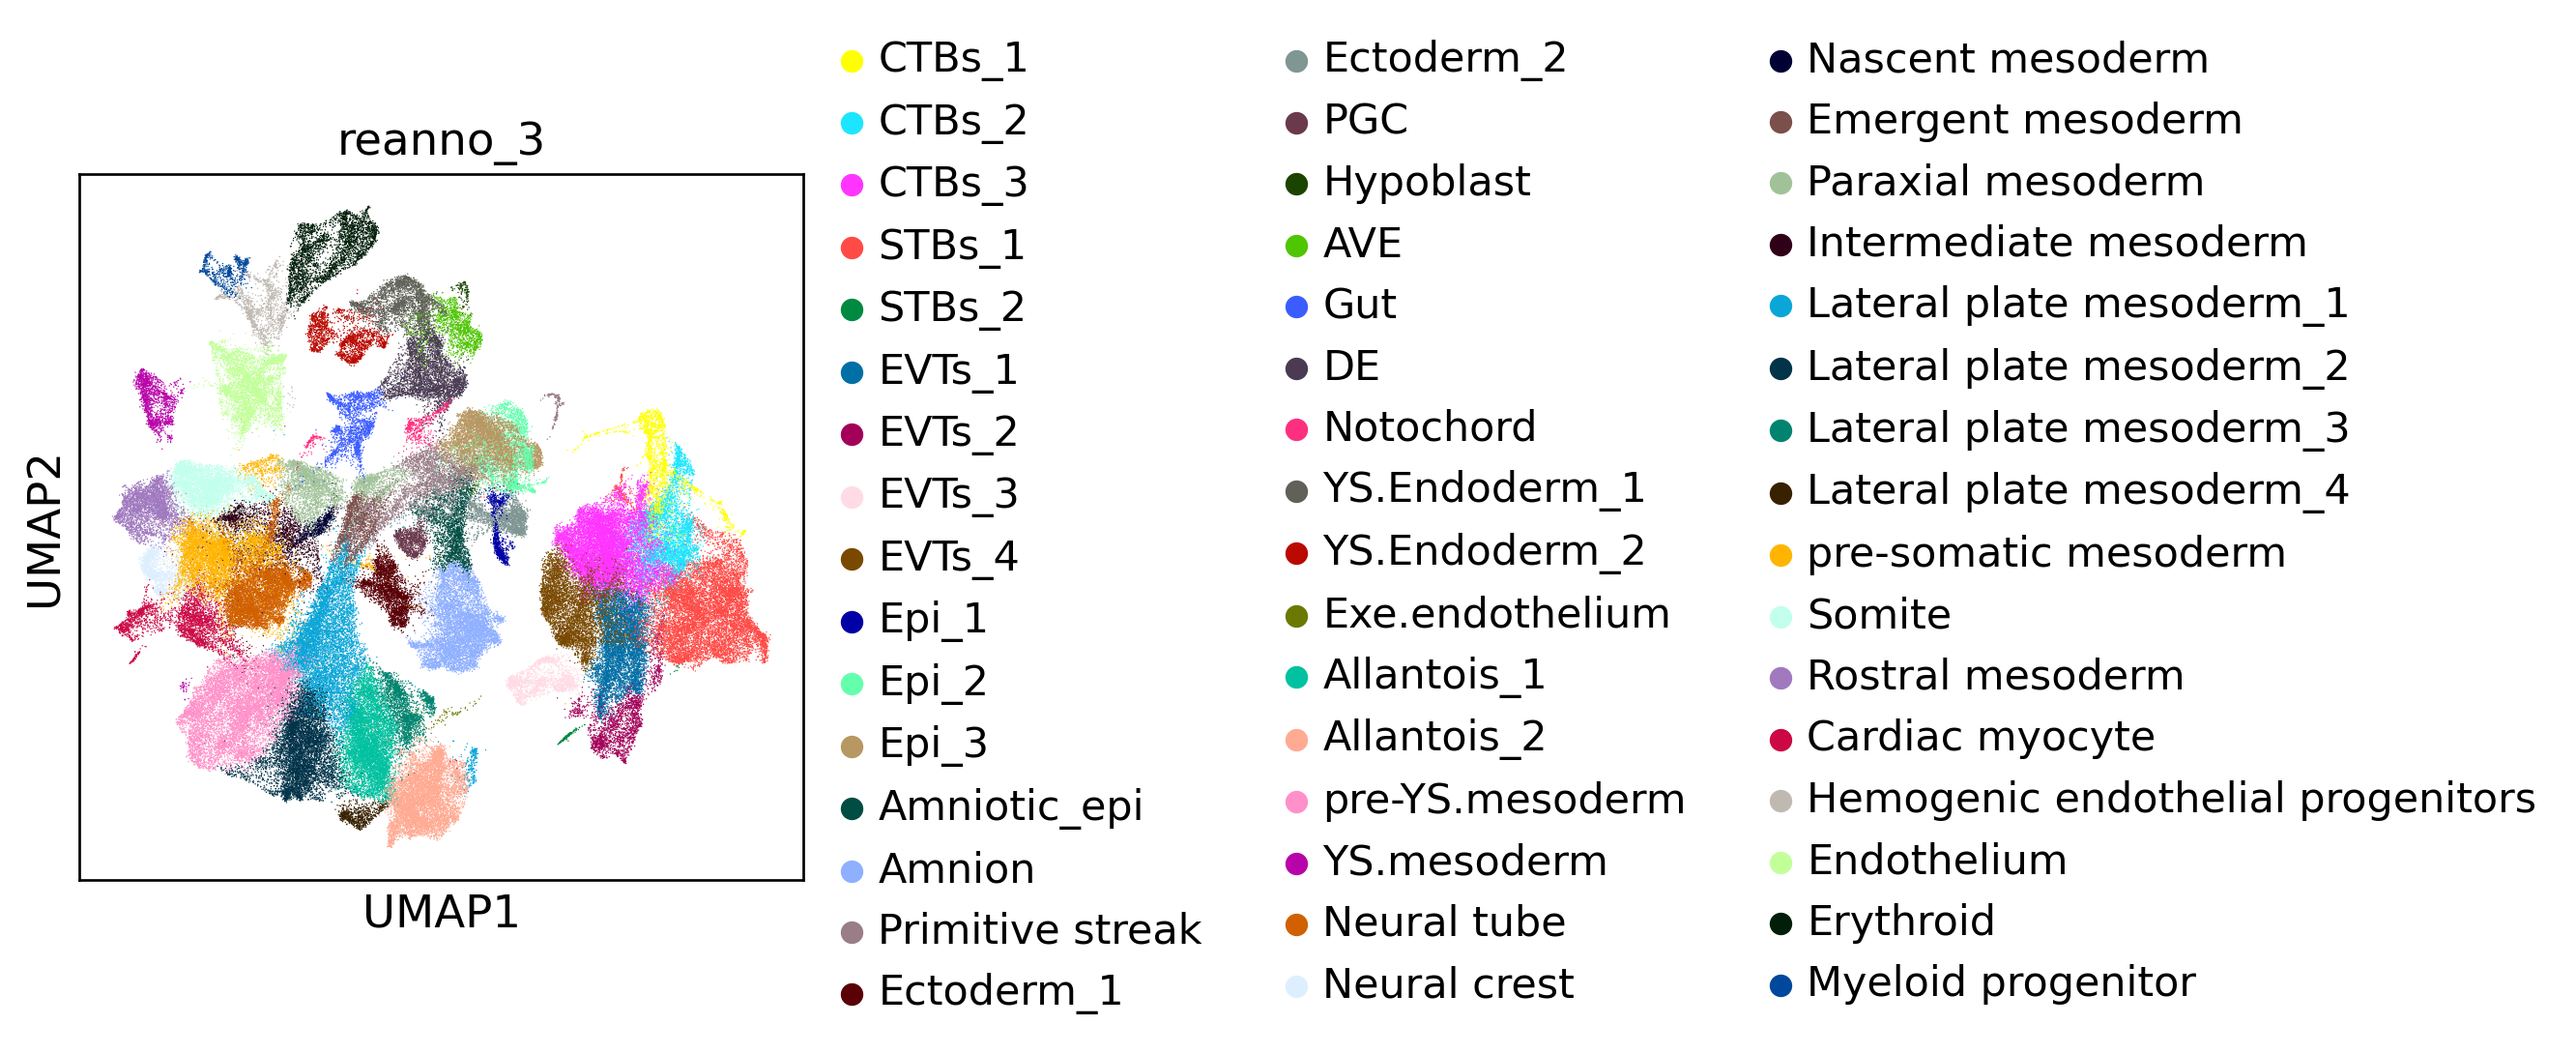

In [4]:
sc.pl.umap(adata, color=['reanno_3'])

In [5]:
# Rename 'reanno_3' to 'crossspecies.anno' in the obs attribute
adata.obs['crossspecies.anno'] = adata.obs.pop('reanno_3')

# Verify the change
print(adata.obs.keys())

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage',
       'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2',
       'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score',
       'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5',
       'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5',
       'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4',
       'reanno', 'lineage', 'unicorns', 'combined_annotation', 'leiden_res0_8',
       'leiden_res1_0', 'leiden_res1_2', 'reanno2', 'leiden_res1_0_sub',
       'crossspecies.anno'],
      dtype='object')

In [6]:
#define lineages
# Define lineages
lineages = {
    'TE_TrB': ['CTBs_1', 'CTBs_2', 'CTBs_3', 'STBs_1', 'STBs_2', 'EVTs_1', 'EVTs_2', 'EVTs_3', 'EVTs_4', ],
    'epi': [ 'Epi_1', 'Epi_2', 'Epi_3',],
    'Gastru': ['Primitive streak', 'Nascent mesoderm',],
    'Notochord': ['Notochord'],
    'PGC': ['PGC'],
    'ExE_endo': ['Hypoblast', 'AVE', 'YS.Endoderm_1', 'YS.Endoderm_2',  ],
    'Exe_meso': [ 'Allantois_1', 'Allantois_2', 'pre-YS.mesoderm', 'YS.mesoderm',  'Exe.endothelium', ],
    'non_neuro_ecto': ['Amnion', 'Amniotic_epi',  'Ectoderm_1', 'Ectoderm_2',],
    'neural_ecto': [ 'Neural tube', 'Neural crest',],
    'Endoderm': ['DE', 'Gut',],
    'mesoderm': [ 'Emergent mesoderm', 'Paraxial mesoderm', 'Intermediate mesoderm', 'Lateral plate mesoderm_1',
    'Lateral plate mesoderm_2', 'Lateral plate mesoderm_3', 'Lateral plate mesoderm_4',
    'pre-somatic mesoderm', 'Somite', 'Rostral mesoderm',
    'Cardiac myocyte', ],
    'hemogenic': ['Hemogenic endothelial progenitors', 'Endothelium', 'Erythroid', 'Myeloid progenitor', ],

    
    
}

# Create a new column 'lineage' with default values
adata.obs['crossspecie.lineage'] = 'Unknown'

# Loop through each lineage and assign the corresponding cells
for lineage, annotations in lineages.items():
    adata.obs.loc[adata.obs['crossspecies.anno'].isin(annotations), 'crossspecie.lineage'] = lineage

# Save the updated AnnData object if needed
# adata.write('path_to_save/adata_with_lineage.h5ad')

# Verify the changes
adata.obs['crossspecie.lineage'].value_counts()


TE_TrB            44994
mesoderm          44367
Exe_meso          26117
non_neuro_ecto    14994
hemogenic          9851
neural_ecto        8733
epi                8597
ExE_endo           6550
Endoderm           5869
Gastru             3540
PGC                1052
Notochord           610
Name: crossspecie.lineage, dtype: int64

In [7]:
# reorder "anno" labels
ordered_labels = [ 'CTBs_1', 'CTBs_2', 'CTBs_3', 'STBs_1', 'STBs_2', 'EVTs_1', 'EVTs_2', 'EVTs_3', 'EVTs_4',
                  'Epi_1', 'Epi_2', 'Epi_3',
                   'Allantois_1', 'Allantois_2', 'pre-YS.mesoderm', 'YS.mesoderm',  'Exe.endothelium', 
                  'Amnion', 'Amniotic_epi',  'Ectoderm_1', 'Ectoderm_2',
                  'Neural tube', 'Neural crest',
                  'Primitive streak', 'Nascent mesoderm','PGC',
                  'Emergent mesoderm', 'Paraxial mesoderm', 'Intermediate mesoderm', 'Lateral plate mesoderm_1',
    'Lateral plate mesoderm_2', 'Lateral plate mesoderm_3', 'Lateral plate mesoderm_4',
    'pre-somatic mesoderm', 'Somite', 'Rostral mesoderm',
    'Cardiac myocyte', 
                  'Notochord', 'DE', 'Gut',
                  'Hypoblast', 'AVE', 'YS.Endoderm_1', 'YS.Endoderm_2', 
                  'Hemogenic endothelial progenitors', 'Endothelium', 'Erythroid', 'Myeloid progenitor',
                  
  ]

# Ensure the 'reanno' column is of type 'category' with the specified order
adata.obs['crossspecies.anno'] = pd.Categorical(adata.obs['crossspecies.anno'], categories=ordered_labels, ordered=True)

# Verify the changes
print(adata.obs['crossspecies.anno'].cat.categories)


Index(['CTBs_1', 'CTBs_2', 'CTBs_3', 'STBs_1', 'STBs_2', 'EVTs_1', 'EVTs_2',
       'EVTs_3', 'EVTs_4', 'Epi_1', 'Epi_2', 'Epi_3', 'Allantois_1',
       'Allantois_2', 'pre-YS.mesoderm', 'YS.mesoderm', 'Exe.endothelium',
       'Amnion', 'Amniotic_epi', 'Ectoderm_1', 'Ectoderm_2', 'Neural tube',
       'Neural crest', 'Primitive streak', 'Nascent mesoderm', 'PGC',
       'Emergent mesoderm', 'Paraxial mesoderm', 'Intermediate mesoderm',
       'Lateral plate mesoderm_1', 'Lateral plate mesoderm_2',
       'Lateral plate mesoderm_3', 'Lateral plate mesoderm_4',
       'pre-somatic mesoderm', 'Somite', 'Rostral mesoderm', 'Cardiac myocyte',
       'Notochord', 'DE', 'Gut', 'Hypoblast', 'AVE', 'YS.Endoderm_1',
       'YS.Endoderm_2', 'Hemogenic endothelial progenitors', 'Endothelium',
       'Erythroid', 'Myeloid progenitor'],
      dtype='object')

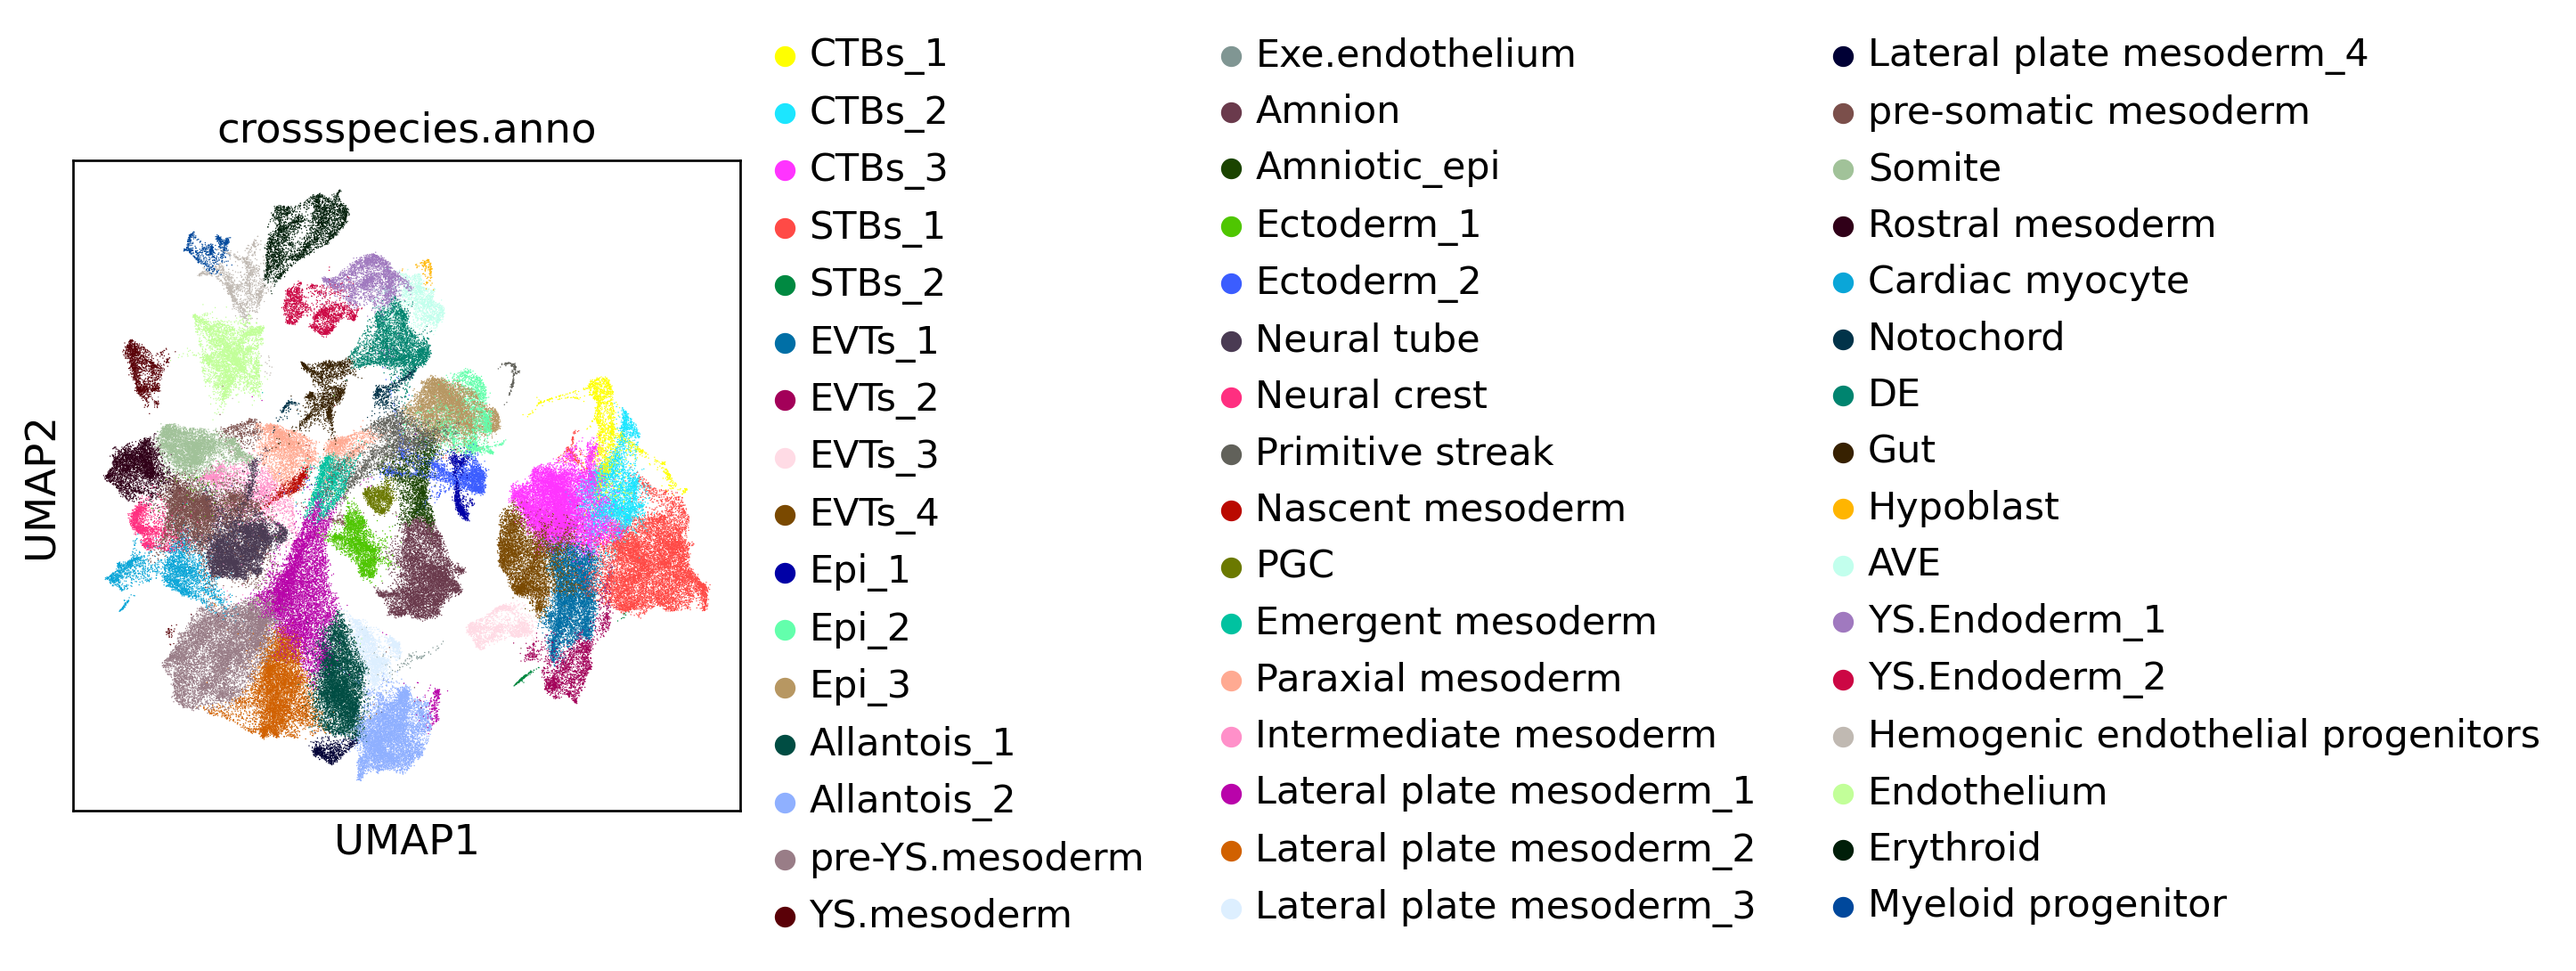

In [8]:
sc.pl.umap(adata, color=['crossspecies.anno'], save='human_monkey_crossspecies.anno.pdf')

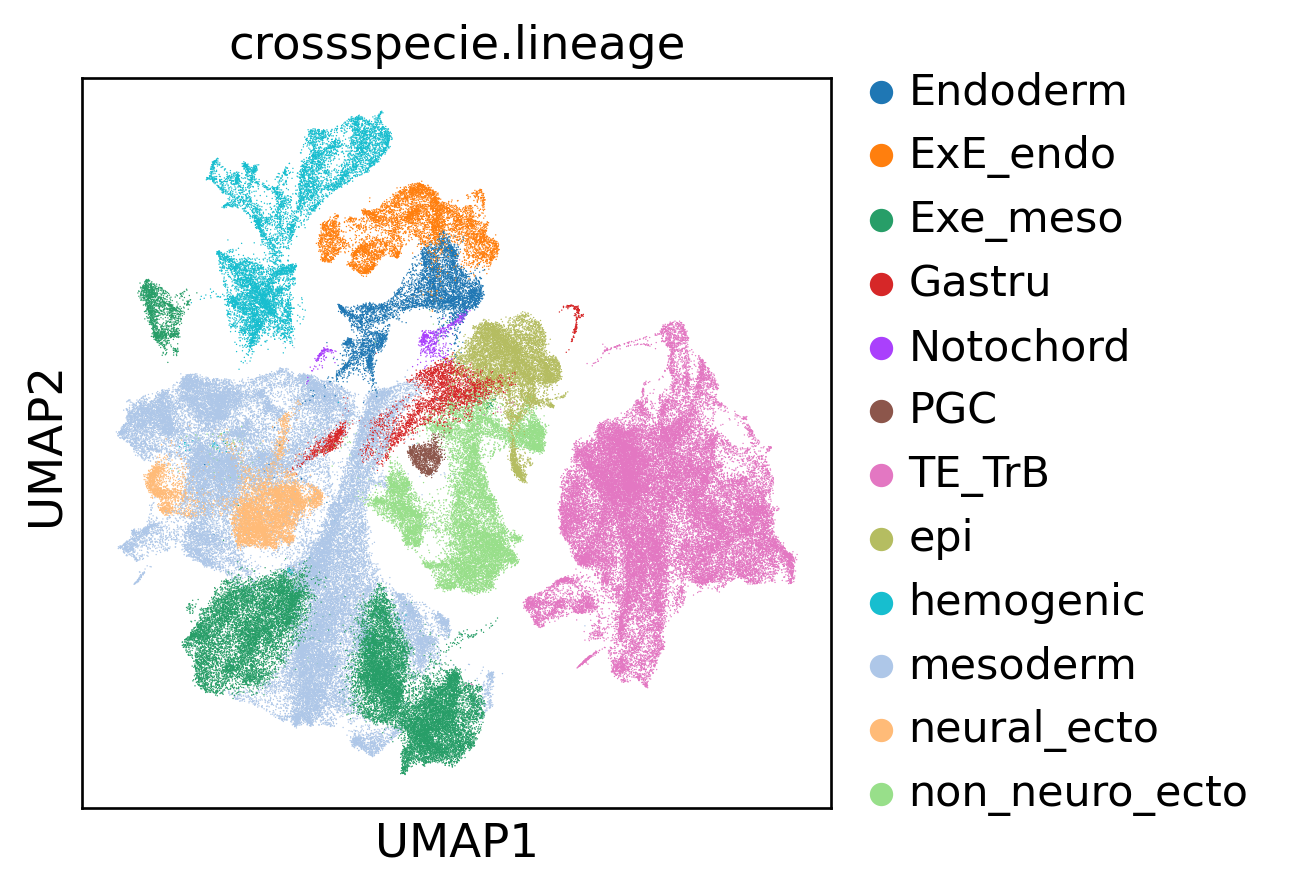

In [9]:
sc.pl.umap(adata, color=['crossspecie.lineage'], save='human_monkey_crossspecie.lineage.pdf')

In [10]:
# Generate UMAP plot without displaying it, but storing the axis for modifications
ax = sc.pl.umap(adata, color=["crossspecies.anno"], groups=['CTBs_1', 'CTBs_2', 'CTBs_3', 'STBs_1', 'STBs_2', 'EVTs_1', 'EVTs_2', 'EVTs_3', 'EVTs_4', ], show=False, return_fig=True)

# Modify the legend text from "NA" to "the rest"
legend_texts = ax.axes[0].get_legend().get_texts()  # Get the legend texts from the plot
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
        legend_text.set_text("the rest")

# Adjust the layout to ensure the legend is fully visible
plt.tight_layout()

# Save the plot with bbox_inches='tight' to prevent legend truncation
plt.savefig('crossspecies.anno_lineage_TE.pdf', dpi=300, bbox_inches='tight')

# Close the plot to free up memory
plt.close()

In [11]:
# focusing on TE/TrB lineage
ana_sub= adata[adata.obs['crossspecies.anno'].isin(['CTBs_1', 'CTBs_2', 'CTBs_3', 'STBs_1', 'STBs_2', 'EVTs_1', 'EVTs_2', 'EVTs_3', 'EVTs_4', ])]

In [12]:

#dot plot
TE_marker_genes = {
    "general": [ "GATA3","TFAP2A","TFAP2C",],
    "TE": [ "TEAD4", "POU5F1","CDX2",],
    "CTBs": [ "ITGA6","FABP5","FGFR1","PEG10","CDH1", ],
    "early_STBs": ["ESRRG","MAFK","TBX20","ATF3",], #"ZNF292",
    "STBs": ["TBX3","CGB2","CGB7","PSG3","PSG6",],
   # "early_EVTs": ["DLX6","HIF1A","NR1H3","DLX5","TFDP2","RXRA",],
    "EVTs":["HLA-G","CSH1","MMP2","ERBB2","KRT7","ASCL2", "SP100", "IRF9", "SP110", "STAT6", "ZNF462",]
   
}

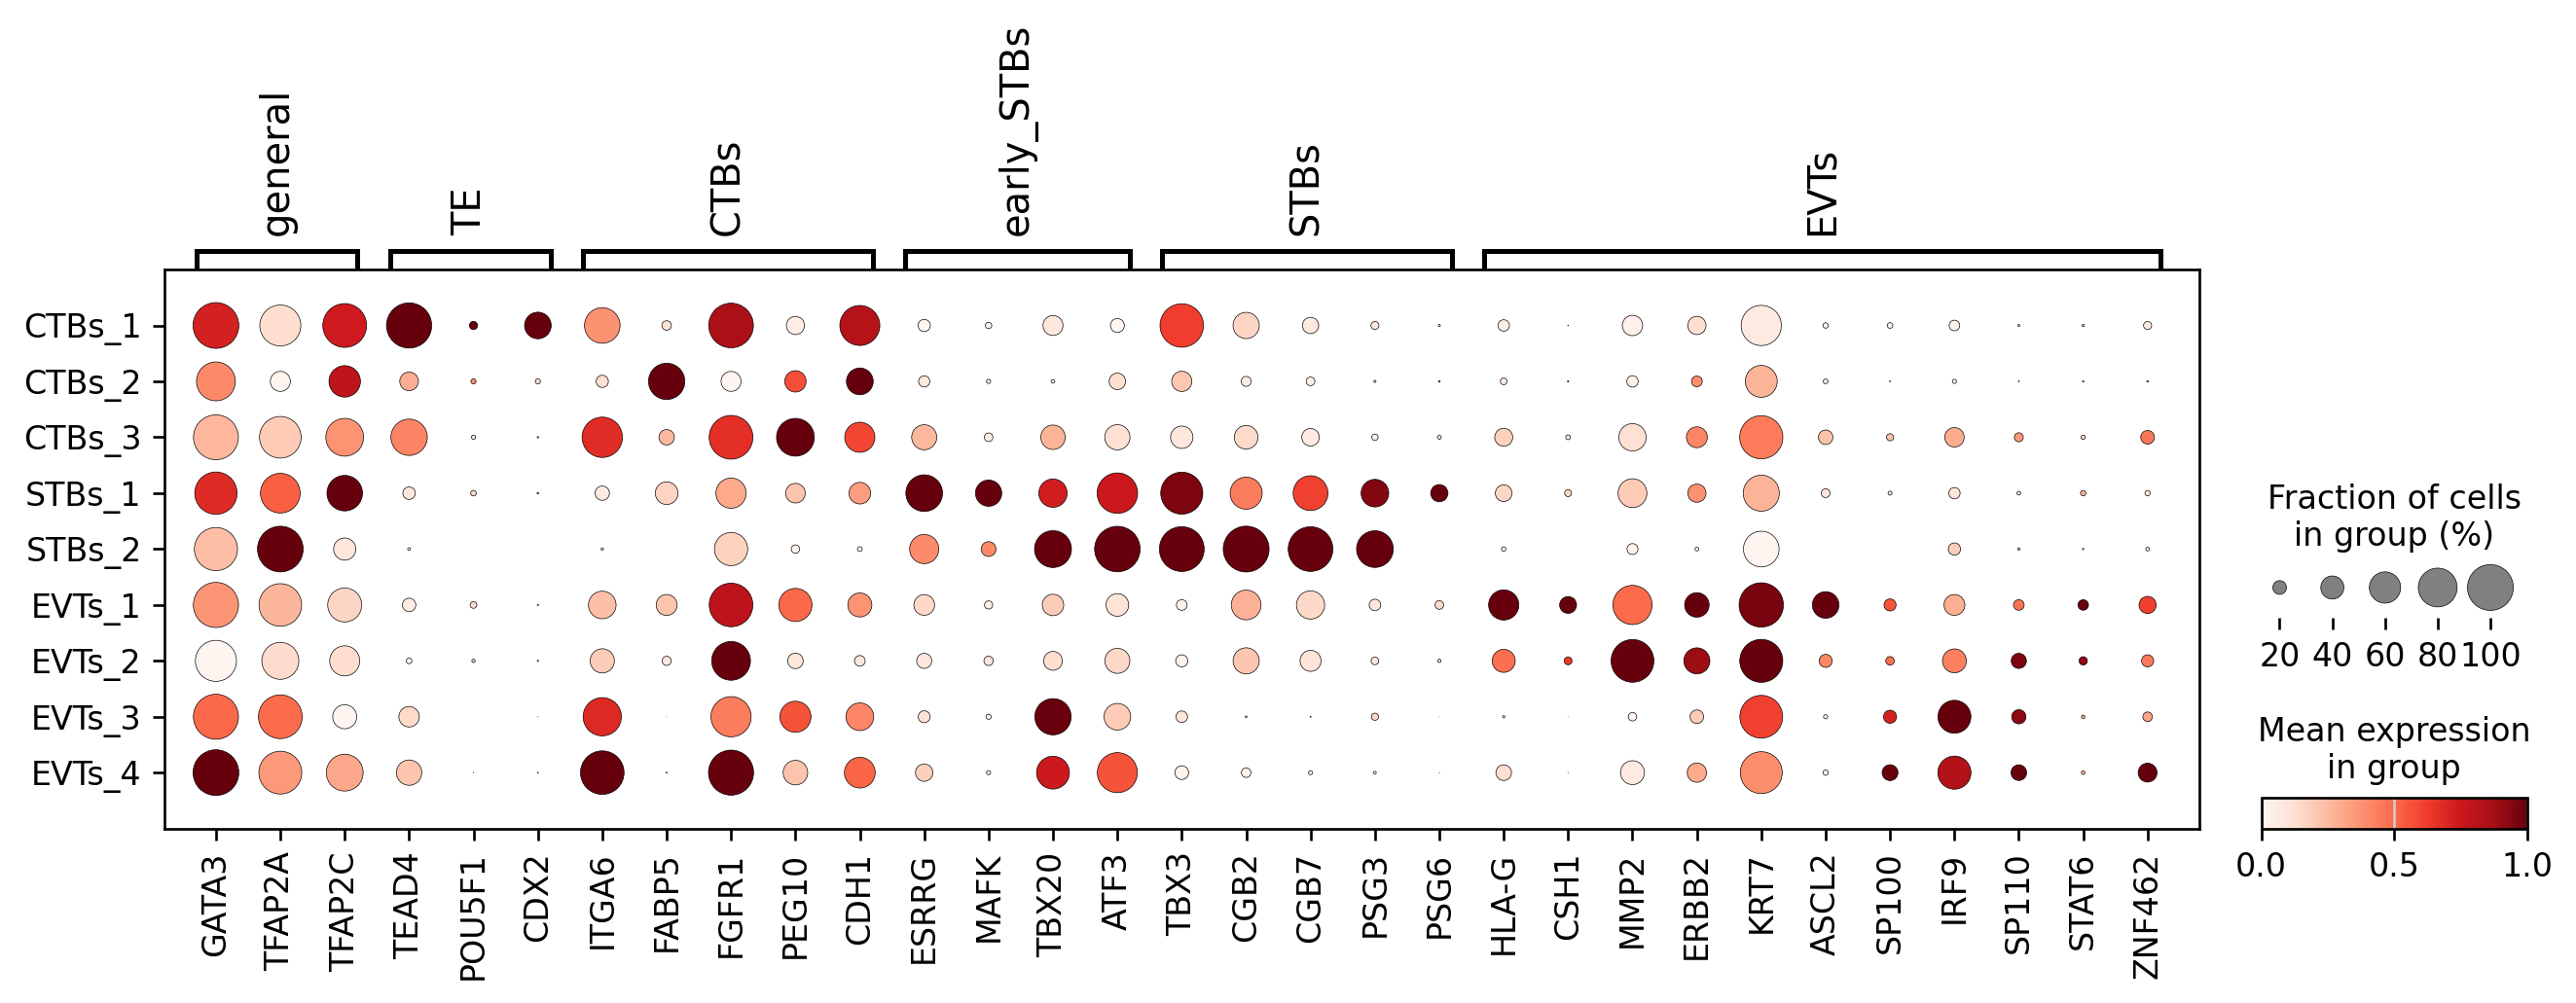

In [13]:
sc.pl.dotplot(ana_sub, TE_marker_genes, groupby="crossspecies.anno", use_raw=False, standard_scale="var", save='crossspecies_TE_marker.pdf' )

In [14]:
# Obtain cluster-specific differentially expressed genes
#sc.tl.rank_genes_groups(ana_sub, groupby="crossspecies.anno", method="wilcoxon",use_raw=False)
#sc.tl.dendrogram(ana_sub, groupby="crossspecies.anno")

#sc.pl.rank_genes_groups_dotplot(ana_sub, groupby="crossspecies.anno", standard_scale="var", n_genes=5,use_raw=False, save='marker')

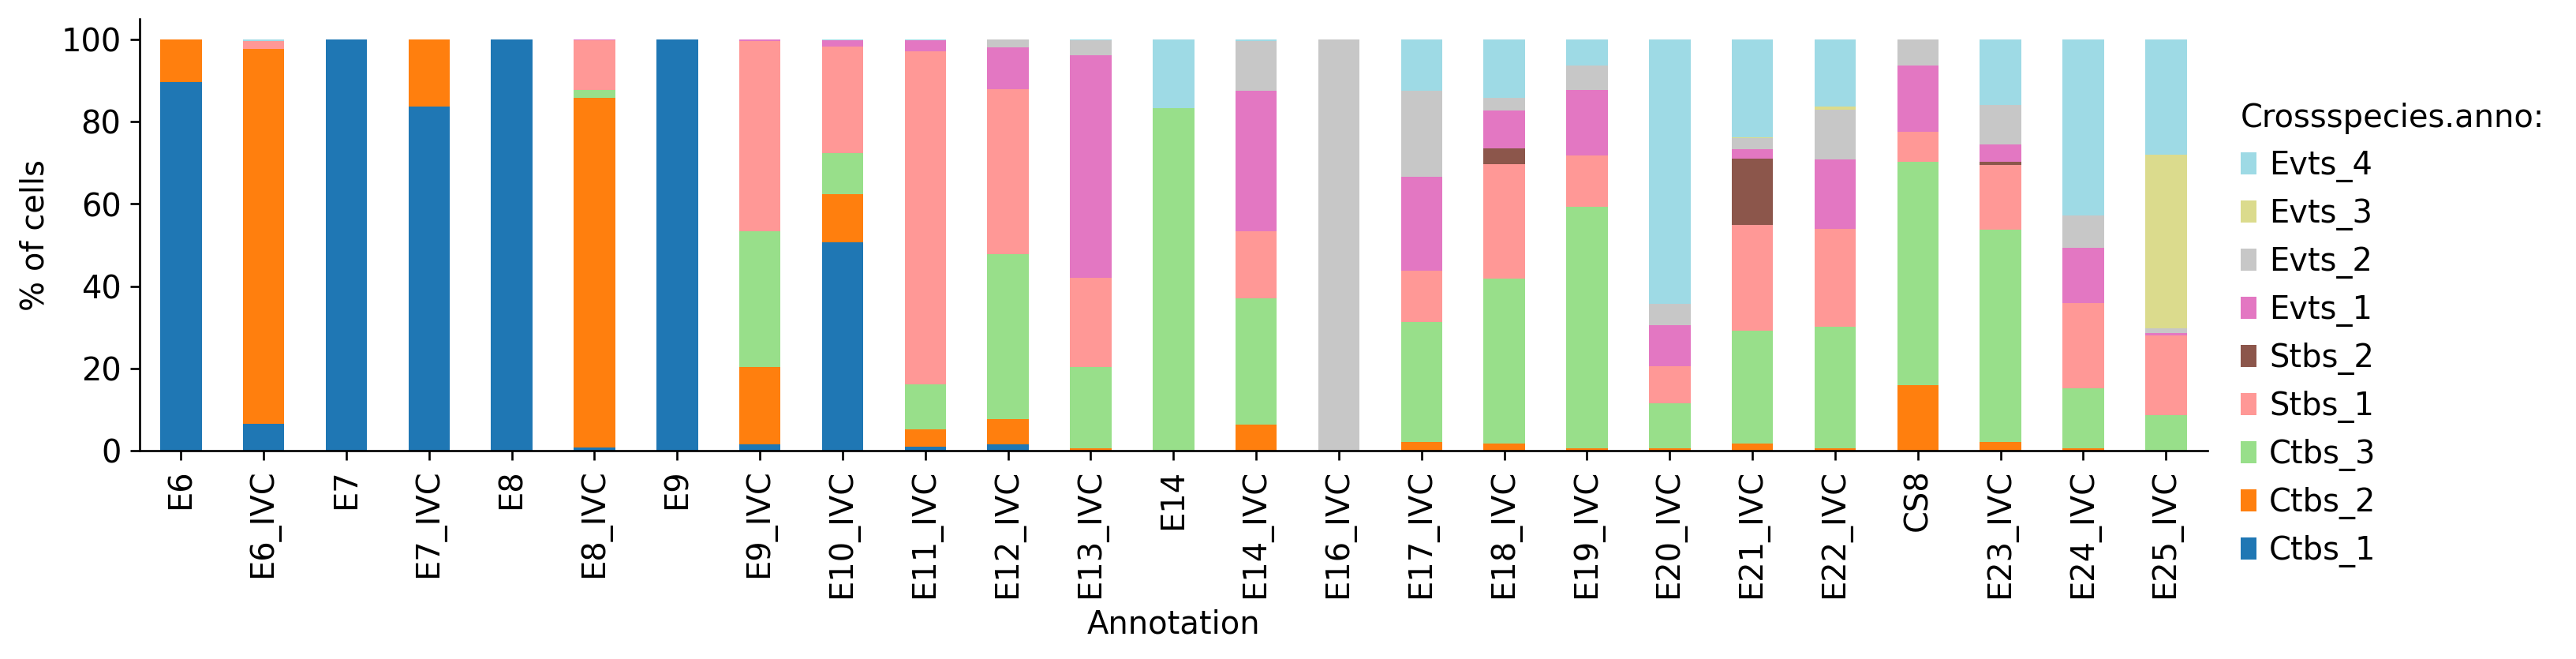

In [15]:
FIGURES = dict()
fz = 12
annos = ['crossspecies.anno']
for x in annos:
    study_count_per_ct = pd.crosstab(ana_sub.obs['stage'], ana_sub.obs[x])
    study_perc_per_ct = (
        study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
    )

    with plt.rc_context(
        {
            "figure.figsize": (14, 3),
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.labelsize": fz,
            "font.size": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", grid=False)
        handles, labels = ax.get_legend_handles_labels()
        labels = [lab.capitalize() for lab in labels]
        ax.legend(
            handles[::-1],
            labels[::-1],
            loc=(1.01, -0.3),
            fontsize=fz,
            frameon=False,
            title=f"{x.capitalize()}:",
        )
        leg = ax.get_legend()
        leg._legend_box.align = "left"
        plt.ylabel("% of cells")
        plt.xlabel("Annotation")
        FIGURES[f"ED_4a_cell_type_{x}"] = fig
        plt.show()

In [16]:
# Plot UMAP with specified colors and groups
ax = sc.pl.umap(adata, color=["crossspecies.anno"], groups=[ 'Hemogenic endothelial progenitors', 'Endothelium','Erythroid','Myeloid progenitor'], show=False, return_fig=True)

# Modify the legend text from "NA" to "the rest"
legend_texts = ax.axes[0].get_legend().get_texts()  # Get the legend texts from the plot
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
        legend_text.set_text("the rest")

# Adjust the layout to ensure the legend is fully visible
plt.tight_layout()

# Save the plot with bbox_inches='tight' to prevent legend truncation
plt.savefig('crossspecies_lineage_hemogenic.pdf', dpi=300, bbox_inches='tight')

# Close the plot to free up memory
plt.close()

In [17]:
# focusing on hemogenic lineage
ana_sub= adata[adata.obs['crossspecies.anno'].isin(['Hemogenic endothelial progenitors', 'Endothelium','Erythroid','Myeloid progenitor'])]

In [18]:
#dot plot
hemato_marker_genes = {
     "Primitive.streak": ["TBXT", "SP5", "HOXA1", "CDX1", "CDX2", "FST" ],
    "endothelial": [ "PECAM1","CDH5", "KDR", "TEK"],
    "erythroid": [ "GATA1", "KLF1", "GYPB", "HBE1","HBZ"],
    "megakatyocyte":["GP1BB", "ITGA2B", "NFE2", ],
    "myeloid progenitor": [ "PTPRC", "CSF1R", "LYVE1",],  
   
}

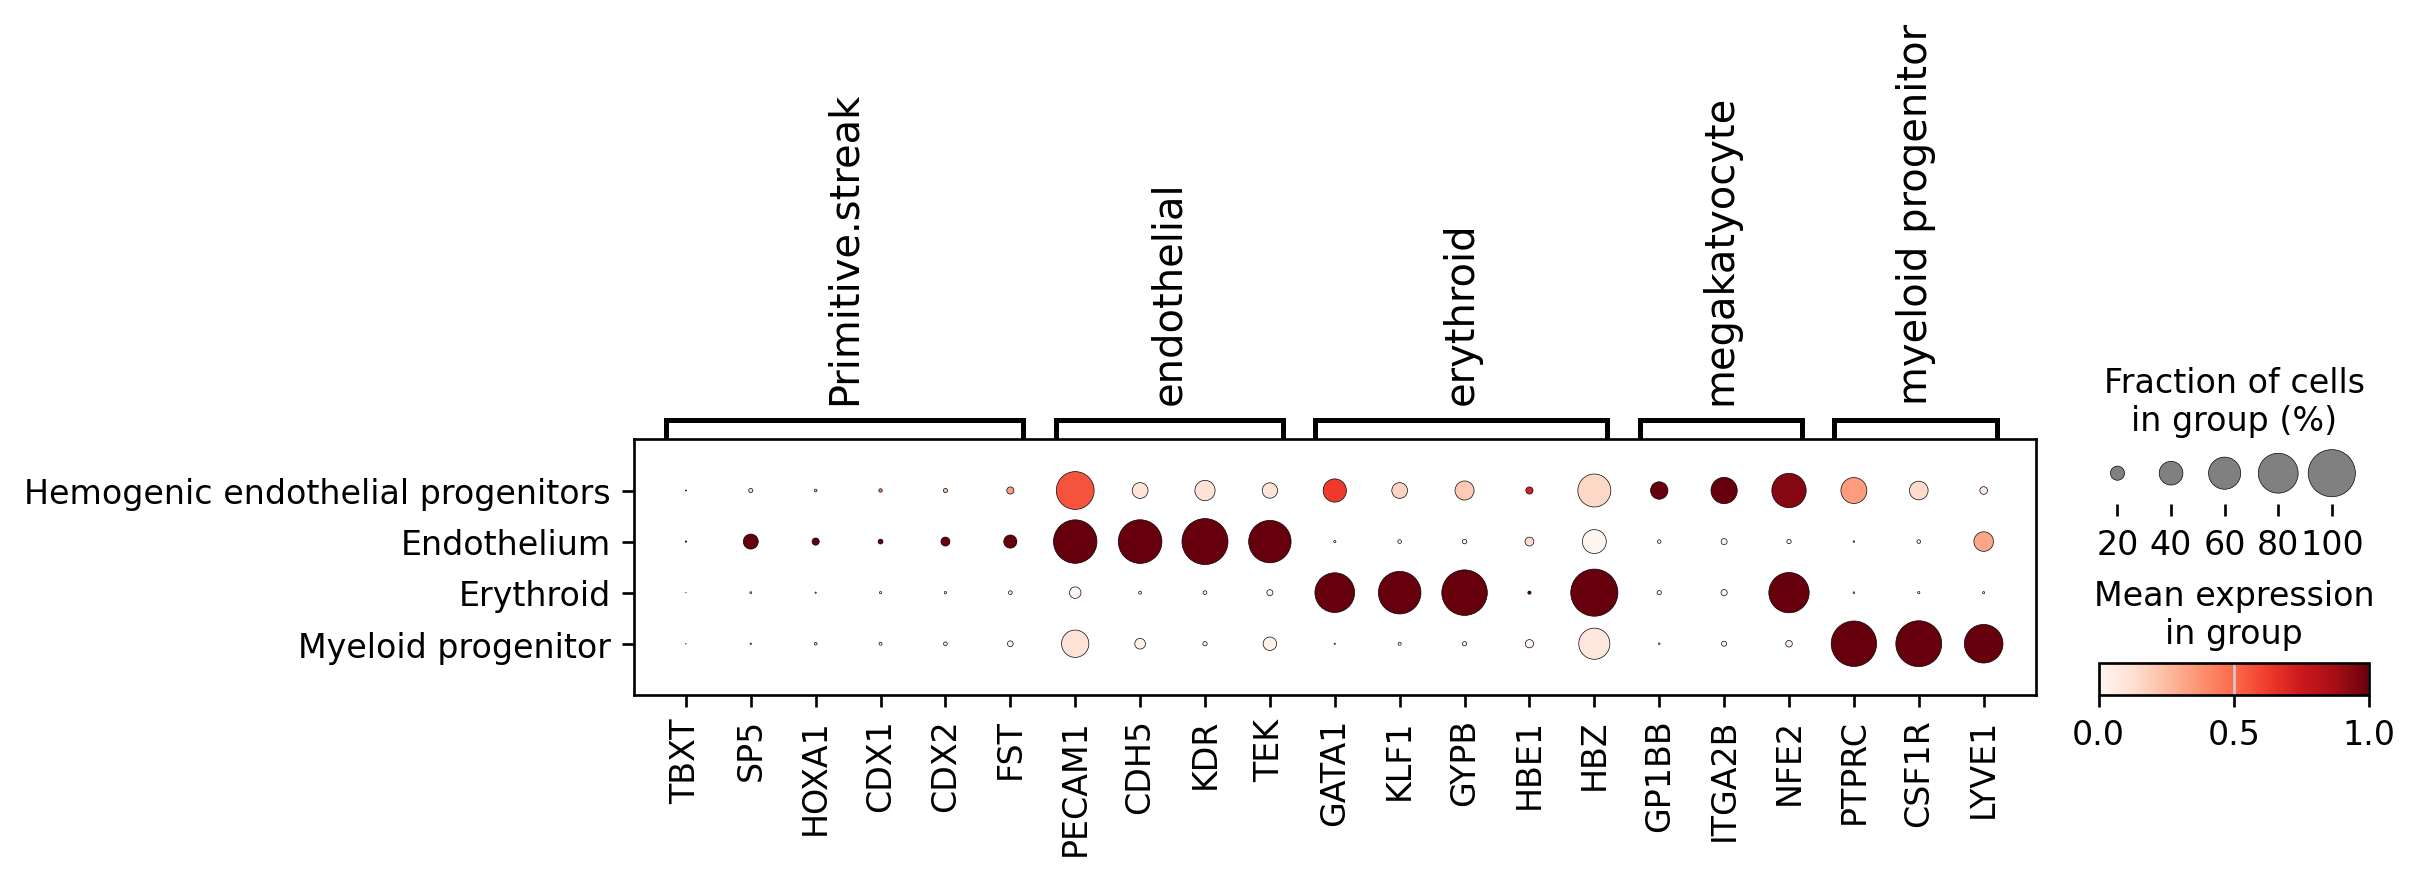

In [19]:
sc.pl.dotplot(ana_sub, hemato_marker_genes, groupby="crossspecies.anno", use_raw=False, standard_scale="var", save='crossspecies_hemogenic_marker.pdf')

In [20]:
# Obtain cluster-specific differentially expressed genes
#sc.tl.rank_genes_groups(ana_sub, groupby="crossspecies.anno", method="wilcoxon",use_raw=False)
#sc.tl.dendrogram(ana_sub, groupby="crossspecies.anno")

#sc.pl.rank_genes_groups_dotplot(ana_sub, groupby="crossspecies.anno", standard_scale="var", n_genes=5,use_raw=False, save='marker')

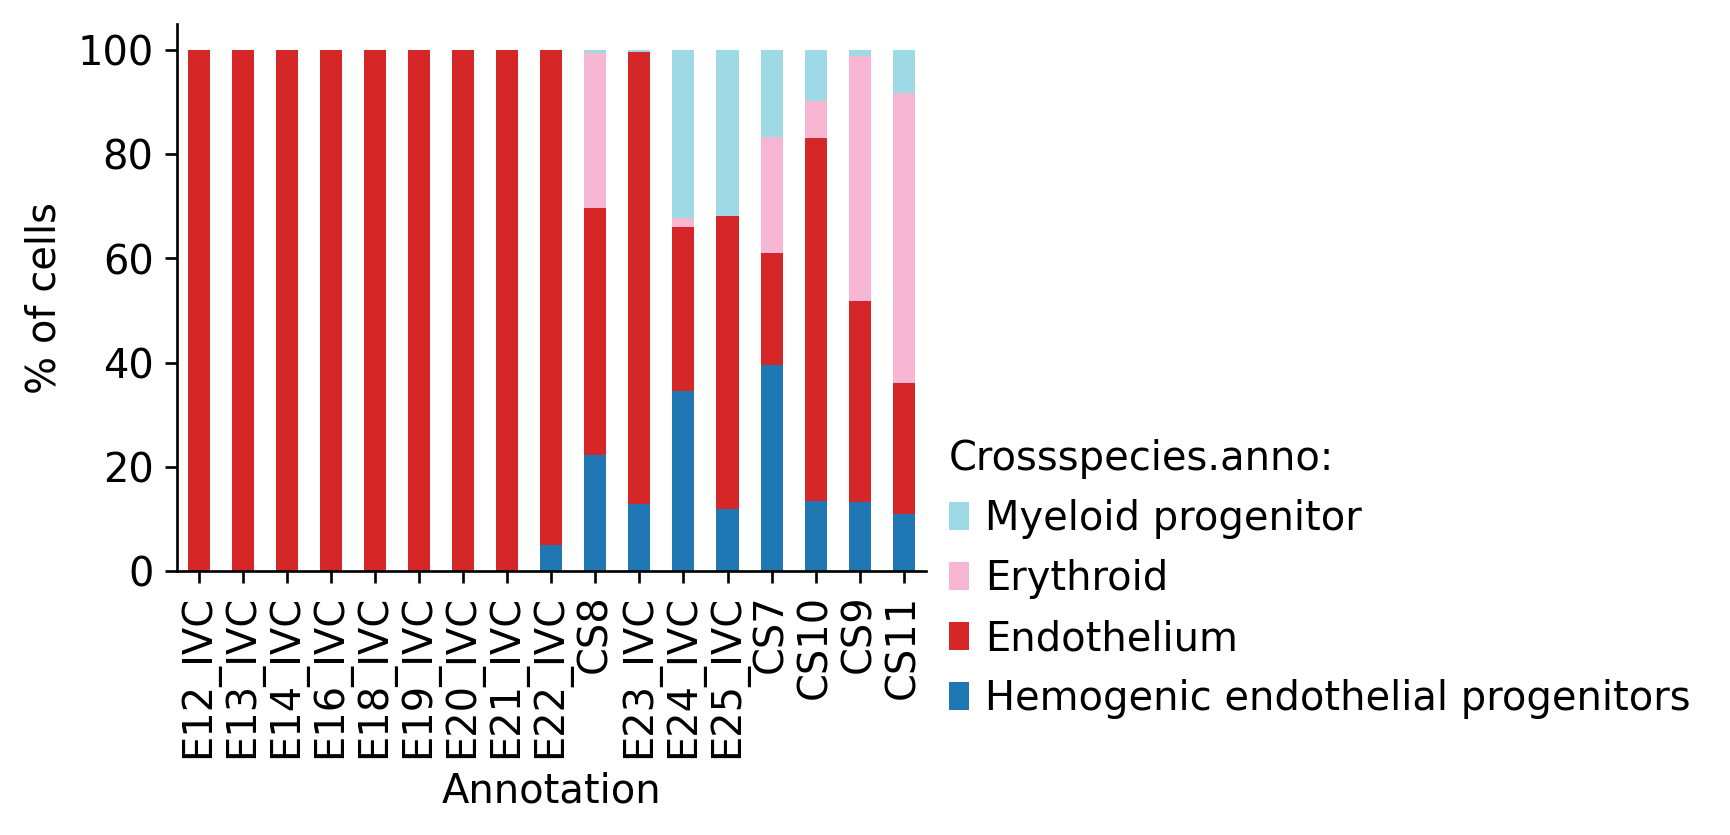

In [21]:
FIGURES = dict()
fz = 12
annos = ['crossspecies.anno']
for x in annos:
    study_count_per_ct = pd.crosstab(ana_sub.obs['stage'], ana_sub.obs[x])
    study_perc_per_ct = (
        study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
    )

    with plt.rc_context(
        {
            "figure.figsize": (4, 3),
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.labelsize": fz,
            "font.size": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", grid=False)
        handles, labels = ax.get_legend_handles_labels()
        labels = [lab.capitalize() for lab in labels]
        ax.legend(
            handles[::-1],
            labels[::-1],
            loc=(1.01, -0.3),
            fontsize=fz,
            frameon=False,
            title=f"{x.capitalize()}:",
        )
        leg = ax.get_legend()
        leg._legend_box.align = "left"
        plt.ylabel("% of cells")
        plt.xlabel("Annotation")
        FIGURES[f"ED_4a_cell_type_{x}"] = fig
        plt.show()

In [22]:
# Plot UMAP with specified colors and groups
ax = sc.pl.umap(adata, color=["crossspecies.anno"], groups=[ 'Emergent mesoderm', 'Paraxial mesoderm', 'Intermediate mesoderm', 'Lateral plate mesoderm_1',
    'Lateral plate mesoderm_2', 'Lateral plate mesoderm_3', 'Lateral plate mesoderm_4',
    'pre-somatic mesoderm', 'Somite', 'Rostral mesoderm',
    'Cardiac myocyte',], show=False, return_fig=True)


# Modify the legend text from "NA" to "the rest"
legend_texts = ax.axes[0].get_legend().get_texts()  # Get the legend texts from the plot
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
        legend_text.set_text("the rest")

# Set the desired figure size (width, height) in inches
ax.set_size_inches(6, 4)  # Adjust width and height as needed

# Adjust the layout to ensure the legend is fully visible
plt.tight_layout()

# Save the plot with bbox_inches='tight' to prevent legend truncation
plt.savefig('crossspecies_lineage_meso_exemeso.pdf', dpi=300, bbox_inches='tight')

# Close the plot to free up memory
plt.close()

In [23]:
# focusing on Meso lineage
ana_sub= adata[adata.obs['crossspecies.anno'].isin([ 'Emergent mesoderm', 'Paraxial mesoderm', 'Intermediate mesoderm', 'Lateral plate mesoderm_1',
    'Lateral plate mesoderm_2', 'Lateral plate mesoderm_3', 'Lateral plate mesoderm_4',
    'pre-somatic mesoderm', 'Somite', 'Rostral mesoderm',
    'Cardiac myocyte', ])]

In [24]:

#dot plot
meso_marker_genes = {
    "Primitive.streak": ["TBXT", "SP5",  "CDX1", "CDX2","MIXL1", "FST", ],
    "meso.general":["PDGFRA", "MESP1",  "GATA6",],
    "emergent.meso": ["LEFTY2", "OTX2","LHX1" ],
    "Nascent.meso":["TBX6","MEIS1",],
    #"Notochord":["CHRD", "NOTO"],
    "Axial.meso": ["DCLK1", ],  #monkey doesn't have "ESRG",
    "Paraxial.meso":["MSGN1", "HES7", ],
    "Caudal.meso":[ "SFRP2", "HOXA1"],
    "Rostral.meso":[ "PITX2", "IRX3"],
    "Intermediate.meso":["PAX8", "OSR1", "EYA1", ],
    "lateral plate.meso":["HAND1", "HAPLN1", "BMP4", "FOXF1", "SNAI2" ],
    "ExE mesoderm progenitor":["LUM", "POSTN", "IGF2", "ANXA1"],
   "YS mesoderm":[ "CREB3L1", "NR2F2", "PLAGL1",  "NID2"],
    #"Allantoic stalk":["CDX1", "CDX2", "FGF9", "FGF18", "SHH", "WNT5B", "MDK"],

   # "myocyte": ["PITX2", "TGFBI"],
    "cardio myocyte":["TNNT2", "MYL7", "TNNI1", "MYH10"],
    "somite":["ALDH1A2",  "MEOX2", "MEOX1",  "FOXC2"],

     "ecto.epi.general":[ "POU5F1", "DNMT3B","EPCAM","CLDN6"],
    #"radial glial":["CDH2", "NES",  "FABP7", "VIM"],
    # "neural.ecto":["SOX3", "PAX6", "TTYH1"],
    # "neural crest":["SOX10", "MPZ", "TFAP2A"],
    # "neural tube":["SOX2", "OTX2", "RFX4"],
   # "proliferating.meso": ["MKI67", "TOP2A", "CDK1" ],
    #"Amniotic.ecto": ["TFAP2C", "GATA3", "MSX2",  "WNT6","DLX5",],
        "EXM": ["DEPDC1B", "FBN2", "FRMD4B", "HAND2", "OAF"],
    "Allantois": ["COL6A2", "COL6A1",  "PCOLCE", "VCAN"],
    "endothelial": [ "PECAM1","CDH5", "KDR", "TEK"],
   
}

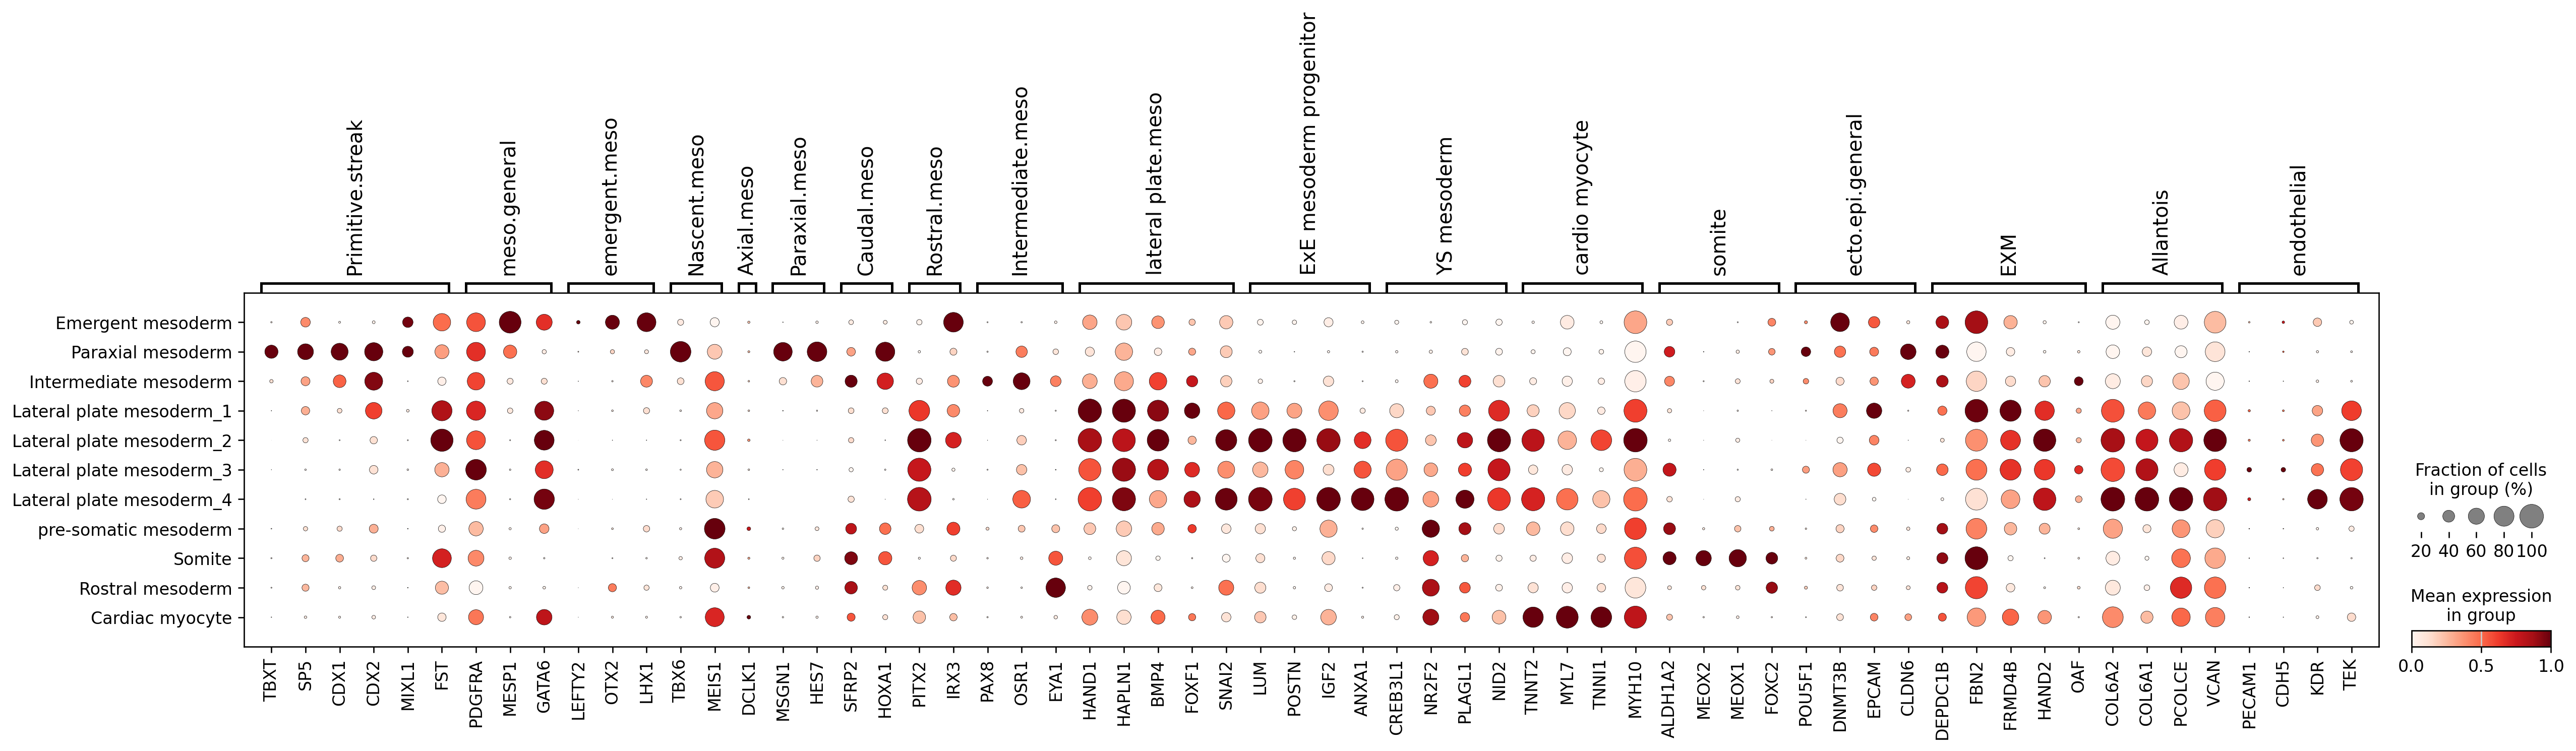

In [25]:
sc.pl.dotplot(ana_sub, meso_marker_genes, groupby="crossspecies.anno", use_raw=False, standard_scale="var", save='crossspecies_mesoderm_marker.pdf')

In [26]:
# Obtain cluster-specific differentially expressed genes
#sc.tl.rank_genes_groups(ana_sub, groupby="crossspecies.anno", method="wilcoxon",use_raw=False)
#sc.tl.dendrogram(ana_sub, groupby="crossspecies.anno")

#sc.pl.rank_genes_groups_dotplot(ana_sub, groupby="crossspecies.anno", standard_scale="var", n_genes=5,use_raw=False, save='marker')

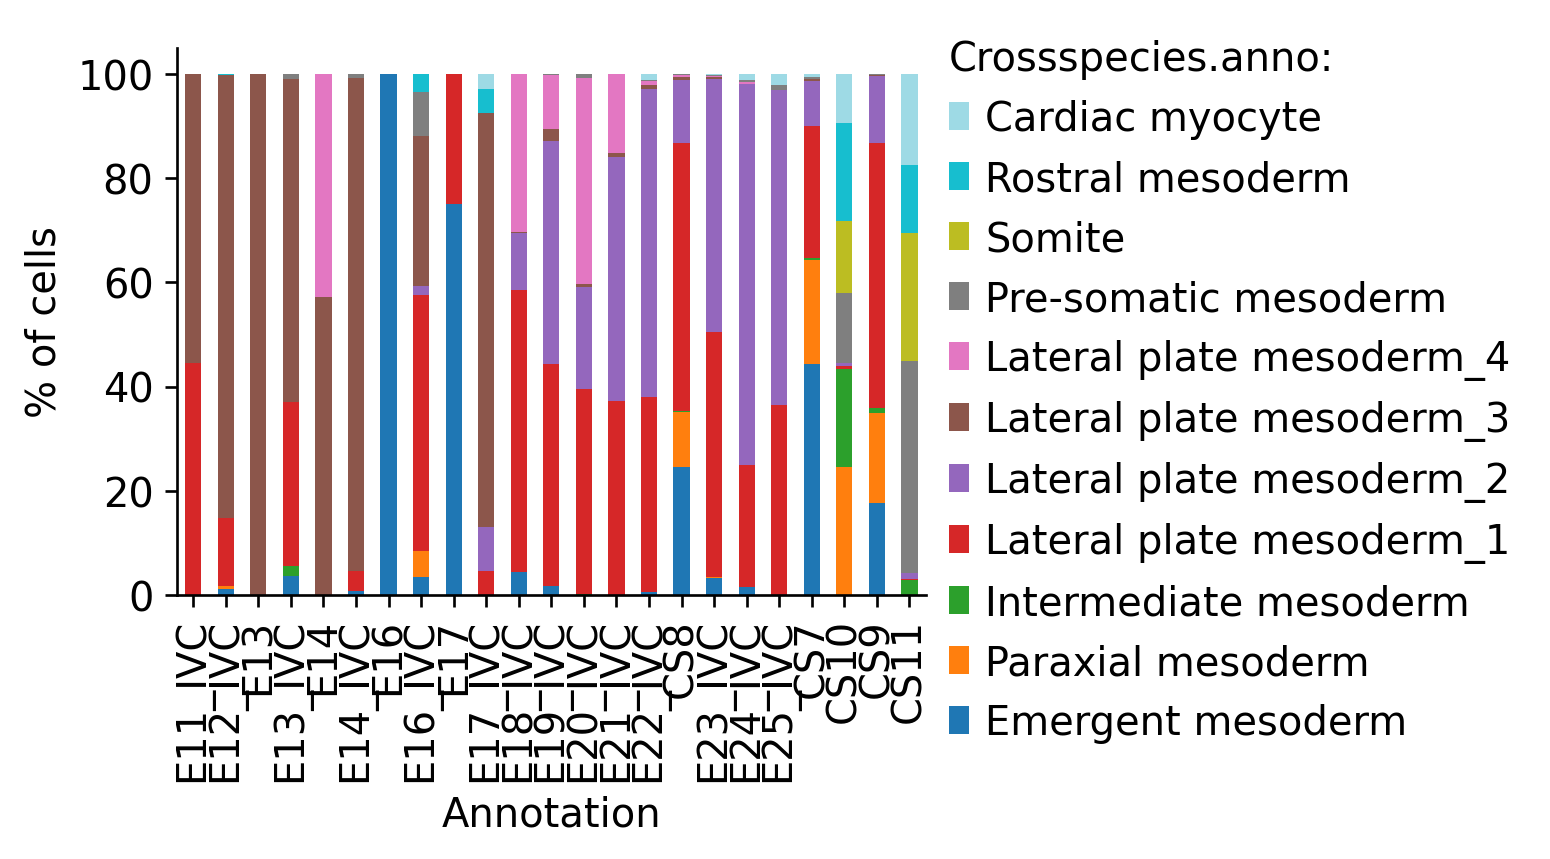

In [27]:
FIGURES = dict()
fz = 12
annos = ['crossspecies.anno']
for x in annos:
    study_count_per_ct = pd.crosstab(ana_sub.obs['stage'], ana_sub.obs[x])
    study_perc_per_ct = (
        study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
    )

    with plt.rc_context(
        {
            "figure.figsize": (4, 3),
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.labelsize": fz,
            "font.size": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", grid=False)
        handles, labels = ax.get_legend_handles_labels()
        labels = [lab.capitalize() for lab in labels]
        ax.legend(
            handles[::-1],
            labels[::-1],
            loc=(1.01, -0.3),
            fontsize=fz,
            frameon=False,
            title=f"{x.capitalize()}:",
        )
        leg = ax.get_legend()
        leg._legend_box.align = "left"
        plt.ylabel("% of cells")
        plt.xlabel("Annotation")
        FIGURES[f"ED_4a_cell_type_{x}"] = fig
        plt.show()

In [28]:
# Plot UMAP with specified colors and groups
ax = sc.pl.umap(adata, color=["crossspecies.anno"], groups=['Epi_1','Epi_2','Epi_3','Epi_4','Epi_5','Epi_6','Amniotic_epi','Amnion_1','Amnion_2','Amnion_3','Amniotic mesoderm',
                    'Epithelium','Ectoderm_1','Ectoderm_2','PGC_1','PGC_2',  'Neural tube_1','Neural tube_2','Neural crest',
                                                'Primitive streak','Nascent mesoderm', 'Allantois_1', 'Allantois_2', 'pre-YS.mesoderm', 'YS.mesoderm',  'Exe.endothelium',], show=False, return_fig=True)

# Modify the legend text from "NA" to "the rest"
legend_texts = ax.axes[0].get_legend().get_texts()  # Get the legend texts from the plot
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
        legend_text.set_text("the rest")

# Set the desired figure size (width, height) in inches
ax.set_size_inches(6, 4)  # Adjust width and height as needed

# Adjust the layout to ensure the legend is fully visible
plt.tight_layout()

# Save the plot with bbox_inches='tight' to prevent legend truncation
plt.savefig('crossspecies_lineage_epi.pdf', dpi=300, bbox_inches='tight')

# Close the plot to free up memory
plt.close()


In [29]:
# focusing on Meso lineage
ana_sub= adata[adata.obs['crossspecies.anno'].isin(['Epi_1','Epi_2','Epi_3','Epi_4','Epi_5','Epi_6','Amniotic_epi','Amnion_1','Amnion_2','Amnion_3','Amniotic mesoderm',
                    'Epithelium','Ectoderm_1','Ectoderm_2','PGC_1','PGC_2',  'Neural tube_1','Neural tube_2','Neural crest',
                                                'Primitive streak','Nascent mesoderm', 'Allantois_1', 'Allantois_2', 'pre-YS.mesoderm', 'YS.mesoderm',  'Exe.endothelium', ])]

In [30]:
#dot plot
all_marker_genes = {
    "epi.general": [ "POU5F1","NANOG","SOX2",],
    "primed Epi":["UTF1", "FGF2", "DNMT3B", "SOX11", "SFRP2", "SALL2" ,],
    "Amniotic.epi": ["TFAP2C", "GATA3", "MSX2", "TFAP2A", "WNT6","DLX5",],
    "Advanced amnion": ["GABRP", "IGFBP3", "IGFBP5",],
    "Primitive.streak": ["TBXT", "SP5", "HOXA1", "CDX1", "CDX2","MIXL1", "FST" ],
    "PGC":["NANOS3", "PDPN", "PRDM1"],
    "epithelium":[ "EPCAM","CLDN6"],
    #"hypoblast":["GATA6","SOX17","PDGFRA","GATA4"],
    "ExE.endoderm progenitor": ["PODXL", "CDH2", "APOA1", "IHH", "FOXA1", "FOXA2", "HNF4A",],
    #"AVE":["LHX1", "HHEX", "EOMES", "GSC", "CER1", "LEFTY1", "LEFTY2","NOG"],
    #"VE/YE":["AFP", "TTR", "APOA4", "APOC3","MTTP","GJB1"],
   # "anterior endoderm": ["HHEX", "OTX2", "SHISA2", "CER1"],
         "neural.ecto":["SOX3", "PAX6", "TTYH1"],
     "neural crest":["SOX10", "MPZ", "TFAP2A"],
     "neural tube":["SOX2", "OTX2", "RFX4"],
        "meso.general":[ "MESP1", "PDGFRA", "GATA6"],
        #"myocyte": ["PITX2", "TGFBI"],
   # "cardio myocyte":["TNNT2", "MYL7", "TNNI1", "MYH10"],
   # "somite":["ALDH1A2",  "MEOX2", "MEOX1"],
      #  "YS.ExE.meso":["GNRH2", "SPINK1","MT2A", "A2M"],
   # "YS.mesothelium":["PODXL", "CDH1"], 
   # "Notochord":["CHRD", "NOTO"],
  "ExE mesoderm progenitor":["LUM", "POSTN", "IGF2", "ANXA1"],
   "YS mesoderm":[ "CREB3L1", "NR2F2", "PLAGL1", "ANXA1", "NID2"],
    #"Allantoic stalk":["CDX1", "CDX2", "FGF9", "FGF18", "SHH", "WNT5B", "MDK"],

   # "myocyte": ["PITX2", "TGFBI"],
    #"radial glial":["CDH2", "NES",  "FABP7", "VIM"],
    # "neural.ecto":["SOX3", "PAX6", "TTYH1"],
    # "neural crest":["SOX10", "MPZ", "TFAP2A"],
    # "neural tube":["SOX2", "OTX2", "RFX4"],
   # "proliferating.meso": ["MKI67", "TOP2A", "CDK1" ],
    #"Amniotic.ecto": ["TFAP2C", "GATA3", "MSX2",  "WNT6","DLX5",],
        "EXM": ["DEPDC1B", "FBN2", "FRMD4B", "HAND2", "OAF"],
    "Allantois": ["COL6A2", "COL6A1",  "PCOLCE", "VCAN"],
    "endothelial": [ "PECAM1","CDH5", "KDR", "TEK"],

 }

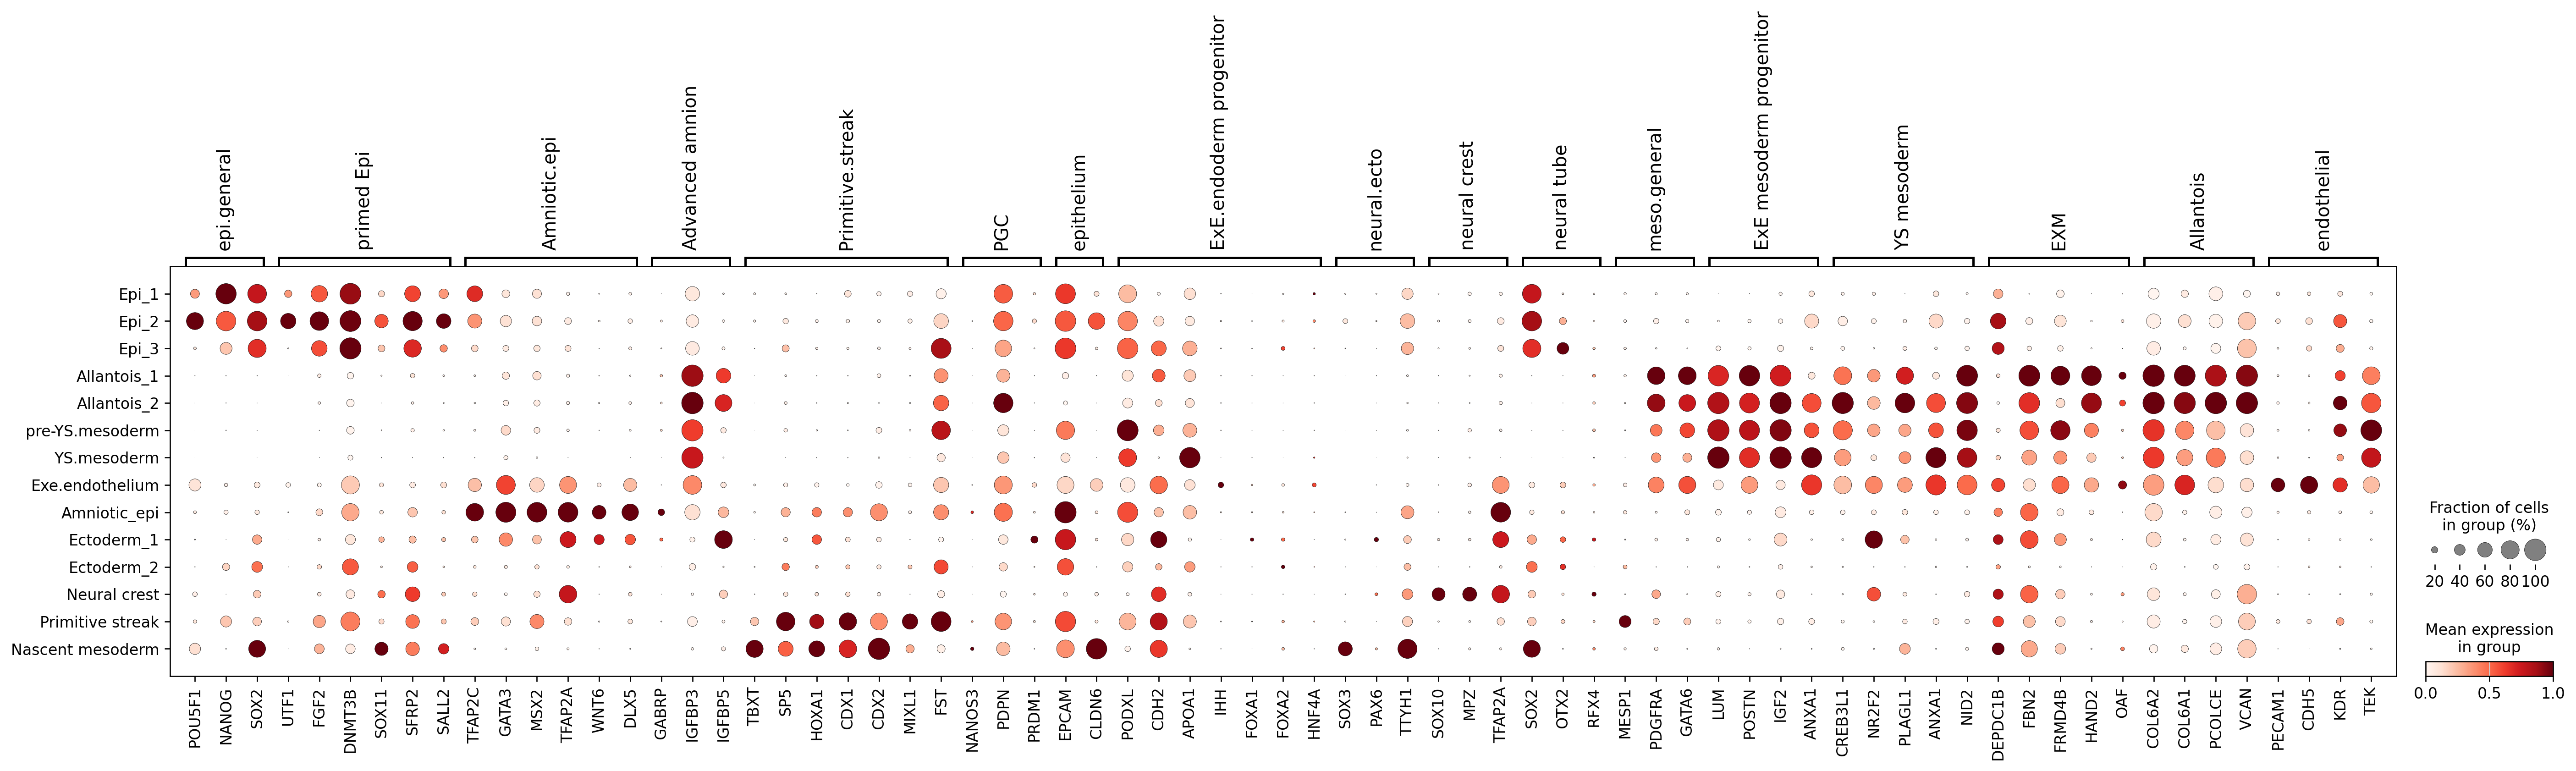

In [31]:
sc.pl.dotplot(ana_sub, all_marker_genes, groupby="crossspecies.anno", use_raw=False, standard_scale="var", save='crossspecies_epi_marker.pdf')

In [32]:
# Plot UMAP with specified colors and groups
ax = sc.pl.umap(adata, color=["crossspecies.anno"], groups=[ 'Hypoblast', 'AVE','YS.Endoderm_1','YS.Endoderm_2','DE', 'Gut', 'Notochord',  ], show=False, return_fig=True)

# Modify the legend text from "NA" to "the rest"
legend_texts = ax.axes[0].get_legend().get_texts()  # Get the legend texts from the plot
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
        legend_text.set_text("the rest")

# Set the desired figure size (width, height) in inches
ax.set_size_inches(6, 4)  # Adjust width and height as needed

# Adjust the layout to ensure the legend is fully visible
plt.tight_layout()

# Save the plot with bbox_inches='tight' to prevent legend truncation
plt.savefig('crossspecies_lineage_endo.pdf', dpi=300, bbox_inches='tight')

# Close the plot to free up memory
plt.close()


In [33]:
# focusing on Meso lineage
ana_sub= adata[adata.obs['crossspecies.anno'].isin([ 'Hypoblast', 'AVE','YS.Endoderm_1','YS.Endoderm_2','DE', 'Gut', 'Notochord', ])]

In [34]:
#dot plot
all_marker_genes = {
    "epi.general": [ "POU5F1","NANOG","SOX2",],
    #"primed Epi":["UTF1", "FGF2", "DNMT3B", "SOX11", "SFRP2", "SALL2" ,],
    #"Amniotic.epi": ["TFAP2C", "GATA3", "MSX2", "TFAP2A", "WNT6","DLX5",],
    #"Advanced amnion": ["GABRP", "IGFBP3", "IGFBP5",],
    "Primitive.streak": ["TBXT", "SP5", "HOXA1", "CDX1", "CDX2","MIXL1", "FST" ],
      "Notochord":["CHRD", "NOTO"],
    #"PGC":["NANOS3", "PDPN", "PRDM1"],
    "epithelium":[ "EPCAM","CLDN6"],
    "hypoblast":["GATA6","SOX17","PDGFRA","GATA4"],
    "ExE.endoderm progenitor": ["PODXL", "CDH2", "APOA1", "IHH", "FOXA1",  "HNF4A",],
    "AVE":["LHX1", "HHEX", "EOMES", "GSC", "CER1", "LEFTY1", "LEFTY2",],
    "VE/YE":["AFP", "TTR", "APOA4", "APOC3","MTTP","GJB1"],
    "DE":["APOA2","FOXA2","UCP2", ], #"RDX",
         "foregut": [ "MECOM","NR4A1","EGFR","BMP4","IFI6",],
    "midgut":["MNX1", "HOXB2", "HOXC9",],
    "hindgut": ["HOXA10", "CXCL12","RSPO3","TMEM88","KITLG", "COL4A1",],
   # "anterior endoderm": ["HHEX", "OTX2", "SHISA2", "CER1"],
         #"neural.ecto":["SOX3", "PAX6", "TTYH1"],
    # "neural crest":["SOX10", "MPZ", "TFAP2A"],
    # "neural tube":["SOX2", "OTX2", "RFX4"],
        "meso.general":[ "MESP1", "PDGFRA", "GATA6"],
        #"myocyte": ["PITX2", "TGFBI"],
   # "cardio myocyte":["TNNT2", "MYL7", "TNNI1", "MYH10"],
   # "somite":["ALDH1A2",  "MEOX2", "MEOX1"],
      #  "YS.ExE.meso":["GNRH2", "SPINK1","MT2A", "A2M"],
   # "YS.mesothelium":["PODXL", "CDH1"], 
  
 # "ExE mesoderm progenitor":["LUM", "POSTN", "IGF2", "ANXA1"],
  # "YS mesoderm":[ "CREB3L1", "NR2F2", "PLAGL1", "ANXA1", "NID2"],
    #"Allantoic stalk":["CDX1", "CDX2", "FGF9", "FGF18", "SHH", "WNT5B", "MDK"],

   # "myocyte": ["PITX2", "TGFBI"],
    #"radial glial":["CDH2", "NES",  "FABP7", "VIM"],
    # "neural.ecto":["SOX3", "PAX6", "TTYH1"],
    # "neural crest":["SOX10", "MPZ", "TFAP2A"],
    # "neural tube":["SOX2", "OTX2", "RFX4"],
   # "proliferating.meso": ["MKI67", "TOP2A", "CDK1" ],
    #"Amniotic.ecto": ["TFAP2C", "GATA3", "MSX2",  "WNT6","DLX5",],
    #    "EXM": ["DEPDC1B", "FBN2", "FRMD4B", "HAND2", "OAF"],
   # "Allantois": ["COL6A2", "COL6A1",  "PCOLCE", "VCAN"],
   #"endothelial": [ "PECAM1","CDH5", "KDR", "TEK"],

 }

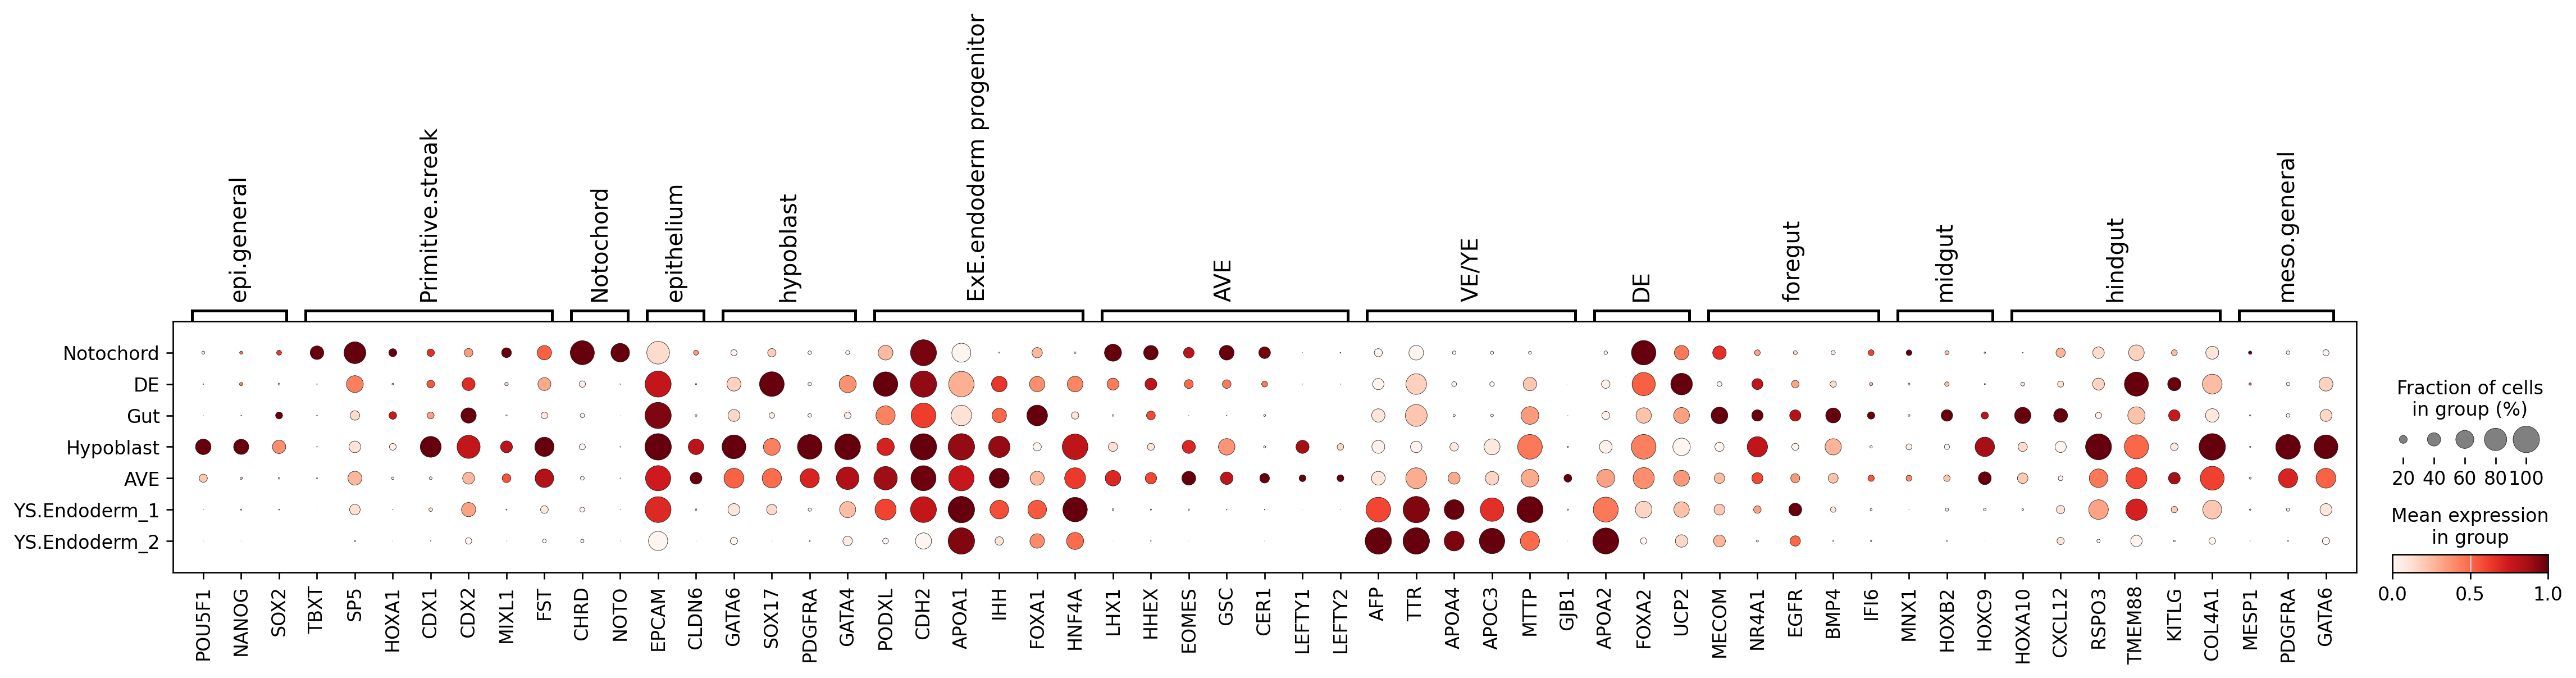

In [35]:
sc.pl.dotplot(ana_sub, all_marker_genes, groupby="crossspecies.anno", use_raw=False, standard_scale="var", save='crossspecies_endo_marker.pdf')